In [8]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pystac_client import Client
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional

catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

In [9]:
# Load the shapefile or GeoJSON representing the land area you want to use for filtering
land_area = gpd.read_file("map_geojson.geojson")  # Replace with the actual path to your GeoJSON file.

# Define the bounding box and datetime range
bbox = [121.30931416717166, 14.571214866470084, 121.35328036802144, 14.605470182520133]
datetime_range = "2015-12-26/2020-12-31"

# Search for Sentinel-2 data
search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime=datetime_range,
)

# Get all items within the specified datetime and bounding box
items = search.get_all_items()

# Create a GeoDataFrame from the items
df = gpd.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")

# Filter the GeoDataFrame to include only items that intersect with the land area
df = df[df.intersects(land_area.unary_union)]

# Explore the filtered GeoDataFrame and display the "s2:vegetation_percentage" column
df[["geometry", "datetime", "s2:vegetation_percentage"]].explore(
    column="s2:vegetation_percentage", style_kwds={"fillOpacity": 0.1}
)


c:\Users\Jesriel John Saramba\Documents\CpE-Related Files\Python\Data Science\lib\site-packages\pystac_client\item_search.py:850: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


c:\Users\Jesriel John Saramba\Documents\CpE-Related Files\Python\Data Science\lib\site-packages\pystac_client\item_search.py:850: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


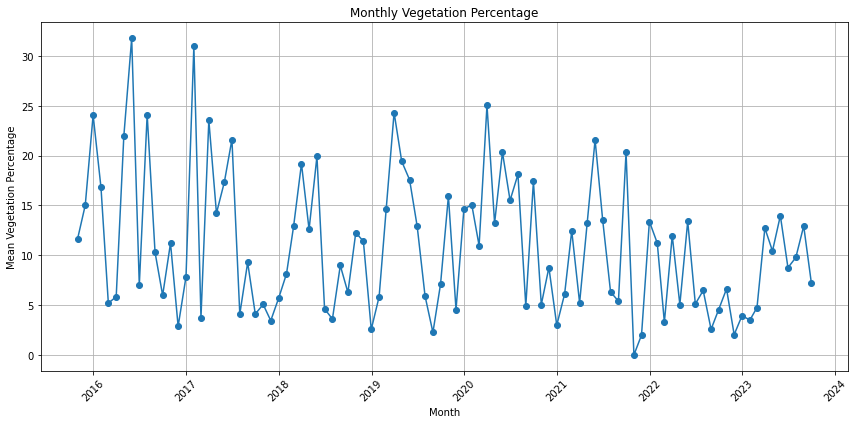

In [10]:
# Load the shapefile or GeoJSON representing the land area you want to use for filtering
land_area = gpd.read_file("map_geojson.geojson")  # Replace with the actual path to your GeoJSON file.

# Define the bounding box and datetime range
bbox = [120.9375, 13.923403897723341, 121.75, 14.63619187839765]
datetime_range = "2013-01-01/2023-10-01"

# Search for Sentinel-2 data
search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime=datetime_range,
)

# Get all items within the specified datetime and bounding box
items = search.get_all_items()

# Create a GeoDataFrame from the items
df = gpd.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")

# Filter the GeoDataFrame to include only items that intersect with the land area
df = df[df.intersects(land_area.unary_union)]

# Sort the GeoDataFrame by datetime
df.sort_values(by="datetime", inplace=True)

# Extract datetime and vegetation_percentage columns
datetime_series = df["datetime"]
vegetation_percentage_series = df["s2:vegetation_percentage"]
df['datetime'] = pd.to_datetime(df['datetime'])
monthly_df = df.resample('M', on='datetime').mean()

# Create a line graph
plt.figure(figsize=(12, 6))
plt.plot(monthly_df.index, monthly_df["s2:vegetation_percentage"], marker='o', linestyle='-')
plt.title('Monthly Vegetation Percentage')
plt.xlabel('Month')
plt.ylabel('Mean Vegetation Percentage')
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the line graph
plt.tight_layout()
plt.show()


In [11]:
monthly_df = monthly_df["s2:vegetation_percentage"]
monthly_df = pd.DataFrame(monthly_df)
monthly_df = monthly_df.rename(columns={"s2:vegetation_percentage":"Vegetation Percentage"})

In [33]:
# Split train data and test data
train_size = int(len(monthly_df)*0.8)

train_data = monthly_df[["Vegetation Percentage"]].iloc[:train_size]
test_data = monthly_df[["Vegetation Percentage"]].iloc[train_size:]

scaler = MinMaxScaler().fit(train_data)
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [34]:
# Create input dataset
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
 
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
 
    return np.array(Xs), np.array(ys)
LOOK_BACK = 5
X_train, y_train = create_dataset(train_scaled,LOOK_BACK)
X_test, y_test = create_dataset(test_scaled,LOOK_BACK)
# Print data shape
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (71, 5, 1)
y_train.shape:  (71, 1)
X_test.shape:  (15, 5, 1)
y_test.shape:  (15, 1)


In [14]:
BI_LSTM = Sequential()
BI_LSTM.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
BI_LSTM.add(Bidirectional(LSTM(64)))
BI_LSTM.add(Dense(20))
BI_LSTM.add(Dense(20))
BI_LSTM.add(Dense(1))

BI_LSTM.compile(optimizer='rmsprop',loss='mse')

BI_LSTM.fit(X_train, y_train, 2, 10, 1, validation_split=0.2)

Epoch 1/10
28/28 [==============================] - 19s 183ms/step - loss: 0.0651 - val_loss: 0.0404
Epoch 2/10
28/28 [==============================] - 1s 36ms/step - loss: 0.0587 - val_loss: 0.0476
Epoch 3/10
28/28 [==============================] - 1s 33ms/step - loss: 0.0625 - val_loss: 0.0398
Epoch 4/10
28/28 [==============================] - 1s 35ms/step - loss: 0.0545 - val_loss: 0.0882
Epoch 5/10
28/28 [==============================] - 1s 32ms/step - loss: 0.0667 - val_loss: 0.0400
Epoch 6/10
28/28 [==============================] - 1s 32ms/step - loss: 0.0608 - val_loss: 0.0405
Epoch 7/10
28/28 [==============================] - 1s 32ms/step - loss: 0.0626 - val_loss: 0.0470
Epoch 8/10
28/28 [==============================] - 1s 32ms/step - loss: 0.0617 - val_loss: 0.0516
Epoch 9/10
28/28 [==============================] - 1s 30ms/step - loss: 0.0593 - val_loss: 0.0388
Epoch 10/10
28/28 [==============================] - 1s 32ms/step - loss: 0.0598 - val_loss: 0.0418


In [15]:
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

In [16]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction
prediction_bilstm = prediction(BI_LSTM)

1/1 [==============================] - 4s 4s/step


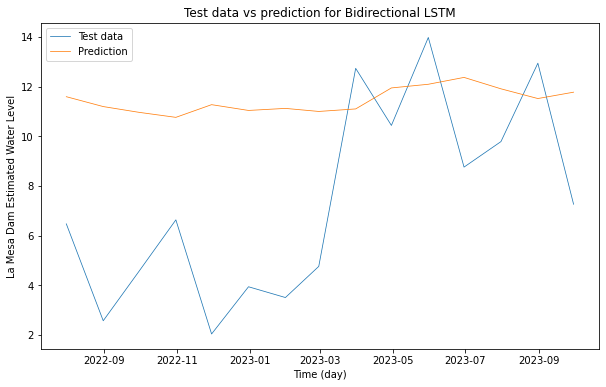

In [17]:
# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    x_labels = monthly_df.index[(monthly_df.index.shape[0] - prediction.shape[0]):]
    plt.figure(figsize=(10, 6))
    plt.plot(np.expand_dims(x_labels, axis=1), np.array(y_test), 
             label='Test data', linewidth=0.75)
    plt.plot(np.expand_dims(x_labels, axis=1), 
             np.array(prediction),label='Prediction', linewidth=0.75)
    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('La Mesa Dam Estimated Water Level')

plot_future(prediction_bilstm, 'Bidirectional LSTM', y_test)

In [18]:
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('Mean Square Error: {:.4f}'.format(mse))
    print('')
evaluate_prediction(prediction_bilstm, y_test, 'Bidirectional LSTM')

Bidirectional LSTM:
Mean Absolute Error: 4.7428
Root Mean Square Error: 5.4123
Mean Square Error: 29.2933



In [31]:
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [35]:
LSTModel = Sequential()
LSTModel.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
LSTModel.add(LSTM(64, return_sequences=True))
LSTModel.add(LSTM(64))
LSTModel.add(Dense(20))
LSTModel.add(Dense(1))

LSTModel.compile(optimizer='rmsprop',loss='mse')

LSTModel.fit(X_train, y_train, 64, 20, 1, validation_split=0.2)

Epoch 1/20


In [27]:
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

In [28]:
prediction_lstm = prediction(LSTModel)
evaluate_prediction(prediction_lstm, y_test, 'LSTM')

1/1 [==============================] - 2s 2s/step
LSTM:
Mean Absolute Error: 5.2621
Root Mean Square Error: 6.1480
Mean Square Error: 37.7985



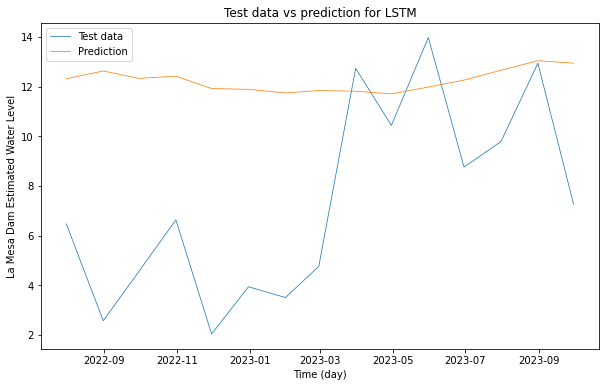

In [29]:
plot_future(prediction_lstm, 'LSTM', y_test)

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 36ms/step
[[11.041722  ]
 [11.36374528]
 [11.61496952]
 [11.81134846]
 [11.96434393]]


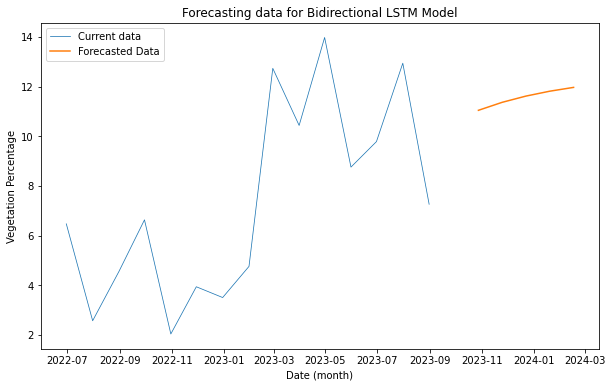

In [117]:
# Plot test data vs prediction
def forecast(historical_data, model_name, model_text, x_test, y_test, months = 1):
    forecast_lookback = x_test[-1]
    predictions = []
    for i in range(1, months + 1):
        f_pred = model_name.predict(np.expand_dims(forecast_lookback, axis=0))
        forecast_lookback = list(forecast_lookback)
        forecast_lookback.append(np.array(f_pred[0]))
        forecast_lookback = np.array(forecast_lookback)
        predictions.append(f_pred[0])
    last_x_lbl = historical_data.index[-1]
    next_x_lbl = [last_x_lbl + timedelta(weeks=(4 * m)) for m in range(1, months + 1)]
    predictions = scaler.inverse_transform(predictions)
    print(predictions)
    x_labels = historical_data.index[-(x_test.shape[0] + 1):-1]
    # print(next_x_lbl, predictions, forecast_lookback)
    plt.figure(figsize=(10, 6))
    plt.plot(np.expand_dims(x_labels, axis=1), np.array(y_test), 
             label='Current data', linewidth=0.75)
    plt.plot(np.expand_dims(next_x_lbl, axis=1), 
             np.array(predictions),label='Forecasted Data')
    plt.title('Forecasting data for ' + model_text)
    plt.legend(loc='upper left')
    plt.xlabel('Date (month)')
    plt.ylabel('Vegetation Percentage')

forecast(monthly_df, LSTModel, "LSTM Model", X_test, y_test, months=5)

1/1 [==============================] - 0s 40ms/step
[[12.84192562]
 [13.61413335]
 [14.27477112]
 [14.82597878]
 [15.27090407]]


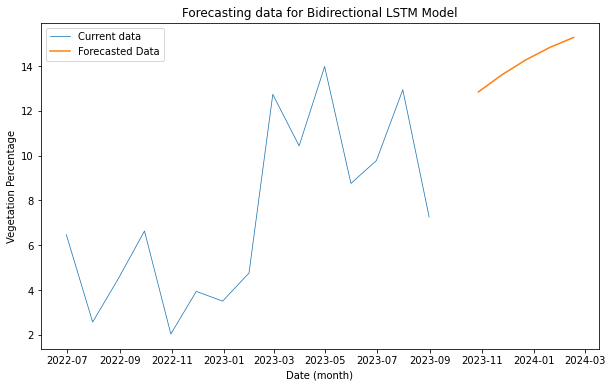

In [118]:
forecast(monthly_df, BI_LSTM, "Bidirectional LSTM Model", X_test, y_test, months=5)

In [119]:
BI_LSTM.save("Vegetation_Percentage_BI_LSTM.h5")
LSTModel.save("Vegetation_Percentage_LSTModel.h5")